<a href="https://colab.research.google.com/github/pradnya-git-dev/W22_COMP6321_Project/blob/main/w22_m3_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Installing required modules

In [1]:
# Install required modules
!pip install datasets
!pip install transformers
!pip install umap-learn

     |████████████████████████████████| 325 kB 7.6 MB/s 
     |████████████████████████████████| 134 kB 78.2 MB/s 
     |████████████████████████████████| 212 kB 70.1 MB/s 
     |████████████████████████████████| 1.1 MB 52.9 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 127 kB 52.2 MB/s 
     |████████████████████████████████| 94 kB 509 kB/s 
     |████████████████████████████████| 144 kB 72.7 MB/s 
     |████████████████████████████████| 271 kB 54.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 8.8 MB/s 


2. Import required modules

In [2]:
# Import required modules
from datasets import load_dataset, DatasetDict, Features, Value, ClassLabel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import torch
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

3. Mounting google drive for accessing dataset files

In [3]:
# Mounting google drive for accessing dataset files
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


4. Creating the dataset

In [4]:
# Creating the dataset
train_file = "/content/drive/MyDrive/2022/College/COMP6321/data/train_dataset_cleaned.csv"
test_file = "/content/drive/MyDrive/2022/College/COMP6321/data/test_dataset_cleaned.csv"

data_files = {"train": train_file, "test": test_file}
class_names = ["negative", "neutral", "positive"]
emotion_features = Features({"id": Value("int64"), "label": ClassLabel(names=class_names), "text": Value("string")})
temp_dataset = load_dataset("csv", data_files=data_files, column_names=["id", "label", "text"], features=emotion_features)

temp_dataset_train_valid = temp_dataset["train"].train_test_split(test_size=0.1)
temp_dataset_train = temp_dataset_train_valid["train"]
temp_dataset_valid = temp_dataset_train_valid["test"]
dataset = DatasetDict({
    "train": temp_dataset_train,
    "valid": temp_dataset_valid,
    "test": temp_dataset["test"]})

# Removing empty text entries
dataset = dataset.filter(lambda example: example["text"] != None)
dataset = dataset.remove_columns("id")

print(dataset)

Using custom data configuration default-197a2373e4fec7aa


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-197a2373e4fec7aa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 25024
    })
    valid: Dataset({
        features: ['label', 'text'],
        num_rows: 2781
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1301
    })
})


5. Checking the data distribution

In [5]:
# Using pandas for checking the data distribution
dataset.set_format(type="pandas")
train_df = dataset["train"][:]

In [6]:
# Printing the first 5 examples in the train data
def label_int2str(row):
  return dataset["train"].features["label"].int2str(row)

train_df["label_name"] = train_df["label"].apply(label_int2str)
train_df.head()

,label,text,label_name
0,0,Panic is far more horrible &amp; infectious th...,negative
1,0,3 million dead two million of whom were civili...,negative
2,2,A good read,positive
3,1,What else is there to say. The President of th...,neutral
4,1,“Democratic” senator Joe Manchin went on Fox N...,neutral


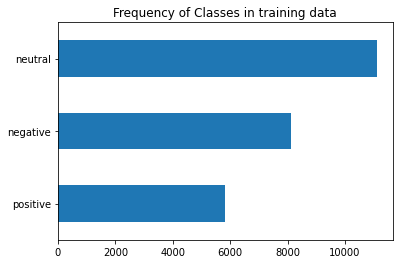

In [7]:
# Displaying the frequency of classes in the training data
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes in training data")
plt.show()

In [8]:
# Resetting the dataset format
dataset.reset_format()

6. Tokenization

In [9]:
# Initializing the tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [10]:
# Defining tokenization function
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [11]:
# Applying the tokenize function across all the datasets (train/validation/test)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

7. Training a classifier (using fine tuning)

In [12]:
# Defining the performance metrics that will be used to evaluate our model's performance during fine-tuning
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average="weighted")
  prec = precision_score(labels, preds, average="weighted")
  rec = recall_score(labels, preds, average="weighted")
  return {"accuracy": acc, "precision": prec, "recall": rec, "f1_score": f1}

In [18]:
# Defining the hyperparameters for the training run and the model
# If new training_args and model are not defined before a training is started the trainer continues training the model that is already trained


batch_size = 64
# logging_steps = len(dataset_encoded["train"])
logging_steps = 50
base_output_dir = "/content/drive/MyDrive/2022/College/COMP6321/saved_models/"
model_output_dir = base_output_dir + model_checkpoint
training_args = TrainingArguments(output_dir=model_output_dir,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="steps",
                                  eval_steps=logging_steps,
                                  logging_strategy="steps",
                                  logging_steps=logging_steps,
                                  disable_tqdm=False,
                                  log_level="error",
                                  save_total_limit=5,
                                  metric_for_best_model="f1_score",
                                  load_best_model_at_end=True)

model_checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3
model3_distilbert = (AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                                        num_labels=num_labels,
                                                                        dropout=0.3).to(device))

In [19]:
class_samples = [9023, 12366, 6416]
class_weights = [1 - (x / sum(class_samples)) for x in class_samples]
class_weights = torch.FloatTensor(class_weights).to(device)

class W22M3Trainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [20]:
# Training the model
trainer = W22M3Trainer(model=model3_distilbert, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["valid"],
                  tokenizer=tokenizer)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
50,1.091900,1.073239,0.396980,0.408515,0.396980,0.375331
100,1.075600,1.063405,0.429702,0.445090,0.429702,0.433261
150,1.059300,1.054332,0.473211,0.467241,0.473211,0.448960
200,1.049700,1.052324,0.462783,0.466663,0.462783,0.438372
250,1.068900,1.049273,0.473571,0.475365,0.473571,0.448481
300,1.059600,1.045651,0.487954,0.482901,0.487954,0.460037
350,1.061500,1.046916,0.463502,0.464412,0.463502,0.455608
400,1.053100,1.043221,0.486516,0.484085,0.486516,0.467832
450,1.036900,1.039687,0.494067,0.491071,0.494067,0.464235
500,1.037500,1.040018,0.485077,0.482432,0.485077,0.474314


TrainOutput(global_step=1173, training_loss=1.038195449881135, metrics={'train_runtime': 843.6502, 'train_samples_per_second': 88.985, 'train_steps_per_second': 1.39, 'total_flos': 3962369256869376.0, 'train_loss': 1.038195449881135, 'epoch': 3.0})

[{'loss': 1.0919, 'learning_rate': 1.9147485080988918e-05, 'epoch': 0.13, 'step': 50}, {'eval_loss': 1.0732393264770508, 'eval_accuracy': 0.3969795037756203, 'eval_precision': 0.4085149791264554, 'eval_recall': 0.3969795037756203, 'eval_f1_score': 0.3753310106450248, 'eval_runtime': 4.7, 'eval_samples_per_second': 591.698, 'eval_steps_per_second': 9.362, 'epoch': 0.13, 'step': 50}, {'loss': 1.0756, 'learning_rate': 1.8294970161977838e-05, 'epoch': 0.26, 'step': 100}, {'eval_loss': 1.0634045600891113, 'eval_accuracy': 0.42970154620640055, 'eval_precision': 0.4450895177556476, 'eval_recall': 0.42970154620640055, 'eval_f1_score': 0.43326091469615363, 'eval_runtime': 4.7792, 'eval_samples_per_second': 581.899, 'eval_steps_per_second': 9.207, 'epoch': 0.26, 'step': 100}, {'loss': 1.0593, 'learning_rate': 1.7442455242966754e-05, 'epoch': 0.38, 'step': 150}]


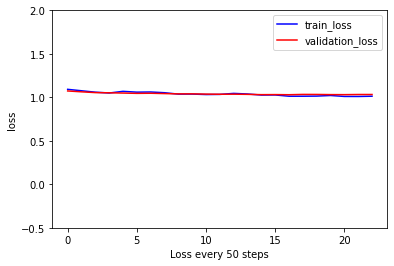

In [21]:
print(trainer.state.log_history[:5])

train_losses = list()
validation_losses = list()

for entry in trainer.state.log_history:
  if "loss" in entry:
    train_losses.append(entry["loss"])
  if "eval_loss" in entry:
    validation_losses.append(entry["eval_loss"])

plt.plot(train_losses, color="blue")
plt.plot(validation_losses, color="red")
plt.ylim(-0.5, 2)
plt.xlabel("Loss every 50 steps")
plt.ylabel("loss")
plt.legend(["train_loss", "validation_loss"])
plt.show()

8. Calculating confusion matrix for validation data

In [22]:
# Normalized confusion matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fix, ax = plt.subplots(figsize=(6, 6))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  cm_display.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

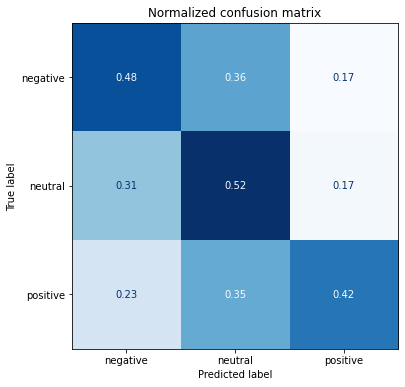

In [23]:
# More detailed look at the training metrics by calculating the confusion matrix

y_valid = np.array(dataset_encoded["valid"]["label"])
labels = dataset["train"].features["label"].names

validation_predictions_all = trainer.predict(dataset_encoded["valid"])
y_preds_validation = np.argmax(validation_predictions_all.predictions, axis=1)
plot_confusion_matrix(y_preds_validation, y_valid, labels)

In [24]:
from sklearn.metrics import classification_report

m3_distilbert_report_v = classification_report(y_valid, y_preds_validation, target_names=labels)
print(m3_distilbert_report_v)

              precision    recall  f1-score   support

    negative       0.46      0.48      0.47       920
     neutral       0.55      0.52      0.53      1258
    positive       0.41      0.42      0.42       603

    accuracy                           0.48      2781
   macro avg       0.47      0.47      0.47      2781
weighted avg       0.49      0.48      0.49      2781



12. Save model

In [27]:
tokenizer.save_pretrained(model_output_dir)
model3_distilbert.save_pretrained(model_output_dir)

13. Load model and calculate confusion matrix for test data

In [28]:
# Load model
loaded_m3 = (AutoModelForSequenceClassification.from_pretrained(model_output_dir, num_labels=num_labels).to(device))
trainer = Trainer(model=loaded_m3)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1301
  Batch size = 8


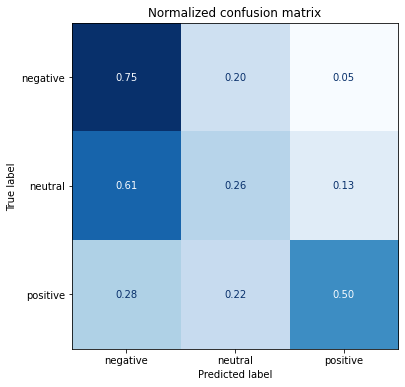

In [29]:
# More detailed look at the training metrics by calculating the confusion matrix

y_test = np.array(dataset_encoded["test"]["label"])

test_predictions_all = trainer.predict(dataset_encoded["test"])
y_preds_test = np.argmax(test_predictions_all.predictions, axis=1)
plot_confusion_matrix(y_preds_test, y_test, labels)

In [30]:
m3_distilbert_report_t = classification_report(y_test, y_preds_test, target_names=labels, output_dict=True)
print(m3_distilbert_report_t)

{'negative': {'precision': 0.5192837465564738, 'recall': 0.748015873015873, 'f1-score': 0.6130081300813008, 'support': 504}, 'neutral': {'precision': 0.3402061855670103, 'recall': 0.2578125, 'f1-score': 0.29333333333333333, 'support': 384}, 'positive': {'precision': 0.7253521126760564, 'recall': 0.49878934624697335, 'f1-score': 0.5911047345767576, 'support': 413}, 'accuracy': 0.5242121445042275, 'macro avg': {'precision': 0.5282806815998469, 'recall': 0.501539239754282, 'f1-score': 0.4991487326637973, 'support': 1301}, 'weighted avg': {'precision': 0.53184366338002, 'recall': 0.5242121445042275, 'f1-score': 0.5117005018763847, 'support': 1301}}
